In [19]:
import os
from pathlib import Path
import torch
import random
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms
import sys
import wandb
from torchinfo import summary

In [20]:
BASE_PATH = Path().resolve().parent # BASE_PATH: /Users/git/link_dl
print(BASE_PATH)
sys.path.append(BASE_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\parkchaeho\link_dl


In [21]:
CLASS_NAMES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


# [문제1] Fashion MNIST 데이터 정규화를 위한 Mean과 Std 값 찾기

In [34]:
stats_transform = transforms.ToTensor()

train_raw = datasets.FashionMNIST(
    root="./_00_data/j_fashion_mnist",
    train=True,
    download=True,
    transform=stats_transform,
)

stats_loader = torch.utils.data.DataLoader(
    train_raw,
    batch_size=len(train_raw),
    shuffle=False
)

images, _ = next(iter(stats_loader))   # images: [60000, 1, 28, 28]

# 3) 채널 단위 mean/std 계산
mean_ = images.mean().item()
std_  = images.std().item()

print("=== FashionMNIST Normalization Statistics ===")
print(f"Mean : {mean_:.4f}")
print(f"Std  : {std_:.4f}")

=== FashionMNIST Normalization Statistics ===
Mean : 0.2860
Std  : 0.3530


# 문제[2] Fashion  MNIST 데이터에 대하여 CNN 학습시키기

In [22]:
def get_fashion_mnist_data(batch_size=256, mean_=0.0, std_=0.0):
    
    data_path = BASE_PATH / "_00_data" / "j_fashion_mnist"

    tfm = transforms.Compose([
        transforms.RandomCrop(28, padding=2),      # padding=2 정도면 과하지 않음
        transforms.RandomHorizontalFlip(),         # 좌우 뒤집기
        transforms.ToTensor(),
        transforms.Normalize(mean=(mean_,), std=(std_,)),
    ])

    f_mnist_train_full = datasets.FashionMNIST(
        root=str(data_path),
        train=True,
        download=True,
        transform=tfm,
    )

    f_mnist_train, f_mnist_validation = random_split(
        f_mnist_train_full, [55_000, 5_000]
    )

    use_cuda = torch.cuda.is_available()
    num_workers = min(os.cpu_count() or 1, 4) if use_cuda else 0
    pin_memory = use_cuda

    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    x0, y0 = f_mnist_train[0]
    print("Sample Data Shape: ", x0.shape)
    print("Sample Data Target:", y0)

    train_data_loader = DataLoader(
        dataset=f_mnist_train,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=pin_memory,
        num_workers=num_workers,
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=pin_memory,
        num_workers=num_workers,
    )

    return train_data_loader, validation_data_loader

In [23]:
def get_fashion_mnist_test_data(batch_size=256, mean_=0.0, std_=0.0):

    data_path = BASE_PATH / "_00_data" / "j_fashion_mnist"
    
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(mean_,), std=(std_,)),
    ])

    f_mnist_test = datasets.FashionMNIST(
        root=str(data_path),
        train=False,
        download=True,
        transform=tfm,
    )

    use_cuda = torch.cuda.is_available()
    num_workers = min(os.cpu_count() or 1, 4) if use_cuda else 0
    pin_memory = use_cuda

    print("Num Test Samples:", len(f_mnist_test))
    print("Sample Shape:", f_mnist_test[0][0].shape)

    test_data_loader = DataLoader(
        dataset=f_mnist_test,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=pin_memory,
        num_workers=num_workers,
    )

    return test_data_loader

In [24]:
def FMNIST_CNN_MODEL():
    """
    Fashion-MNIST용 CNN 모델
    """
    class MyModel(nn.Module):
        def __init__(self, num_classes=10):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(1, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Conv2d(32, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
            
                nn.Conv2d(32, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(32*2, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
            
                nn.Conv2d(64, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(128, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
            )

            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(128*3*3, 512),  # 256 → 512
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, num_classes),
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

    return MyModel()

In [25]:
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples

    return epoch_loss, epoch_accuracy

In [26]:
@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    """
    (필요시) Train/Val 공통 평가용. 현재 main에서는 안 씀.
    """
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, 100.0 * correct / total

In [27]:
def test(model, loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)

            total_loss += loss.item() * x.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    acc = 100.0 * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Test Acc: {acc:.2f}%")
    return avg_loss, acc

In [28]:
@torch.no_grad()
def show_10_test_samples(model, test_loader, device):
    model.eval()

    imgs, labels, preds = [], [], []
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        p = out.argmax(1)
        imgs.append(x.cpu())
        labels.append(y)
        preds.append(p.cpu())

    imgs   = torch.cat(imgs, dim=0)      # [N, 1, 28, 28]
    labels = torch.cat(labels, dim=0)    # [N]
    preds  = torch.cat(preds, dim=0)     # [N]

    right_idx = (preds == labels).nonzero(as_tuple=True)[0].tolist()
    wrong_idx = (preds != labels).nonzero(as_tuple=True)[0].tolist()

    rng = random.Random(42)

    chosen = []
    if wrong_idx:
        chosen.append(rng.choice(wrong_idx))
        pool = list(set(range(len(labels))) - set(chosen))
        rng.shuffle(pool)
        chosen += pool[:9]
    else:
        chosen = rng.sample(range(len(labels)), 10)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(chosen):
        img = imgs[idx].squeeze(0)      # [28, 28]
        true_label = int(labels[idx])
        pred_label = int(preds[idx])
        same = (true_label == pred_label)

        print(f"[{i}] Label: {CLASS_NAMES[true_label]:<12} | "
              f"Pred: {CLASS_NAMES[pred_label]:<12} | Same: {same}")

        ax = plt.subplot(2, 5, i + 1)
        ax.imshow(img.numpy(), cmap="gray")
        ax.axis("off")
        ax.set_title(
            f"T:{CLASS_NAMES[true_label]}\n"
            f"P:{CLASS_NAMES[pred_label]}\nSame:{same}"
        )

    plt.tight_layout()
    plt.show()


In [35]:
def main():
    # 1) 디바이스 확인
    print(f"[INFO] Device: {device}")

    # 2) Train 전체에서 mean/std 계산
    data_path = BASE_PATH / "_00_data" / "j_fashion_mnist"
    stats_transform = transforms.ToTensor()
    train_full_raw = datasets.FashionMNIST(
        root=str(data_path),
        train=True,
        download=True,
        transform=stats_transform,
    )

    stats_loader = DataLoader(
        train_full_raw,
        batch_size=len(train_full_raw),
        shuffle=False,
    )

    images, _ = next(iter(stats_loader))  # [60000, 1, 28, 28]
    mean_ = images.mean().item() # 0.2860
    std_ = images.std().item() # 0.3530

    print("FashionMNIST Dataset Statistics")
    print(f"  Mean: {mean_:.4f}")
    print(f"  Std : {std_:.4f}")

    # 3) 하이퍼파라미터
    batch_size = 256
    epochs = 100
    lr = 1e-3

    print(f"[INFO] batch_size={batch_size}, epochs={epochs}, lr={lr}")

    wandb.init(
        project="DEEP_LEARNING_PRACTICE",
        name="fmnist_cnn_run1",
        config={
            "batch_size": batch_size,
            "epochs": epochs,
            "lr": lr,
            "optimizer": "Adam",
            "model": "SimpleCNN_3conv",
        },
    )
    
    # 4) DataLoader 준비
    train_loader, val_loader = get_fashion_mnist_data(
        batch_size=batch_size,
        mean_=mean_,
        std_=std_,
    )

    test_loader = get_fashion_mnist_test_data(
        batch_size=1024,
        mean_=mean_,
        std_=std_,
    )

    # 5) 모델 / Loss / Optimizer
    model = FMNIST_CNN_MODEL().to(device)

    summary(
    model, 
    input_size=(1, 1, 28, 28),   # (batch, channel, H, W)
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    depth=4,
    )
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=5e-4,
    )

    best_val_acc = 0.0

    # 6) 학습 루프
    for epoch in range(1, epochs + 1):
        # --- Train ---
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / total
        train_acc = 100.0 * correct / total

        # --- Validation ---
        model.eval()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)

        val_loss = total_loss / total
        val_acc = 100.0 * correct / total

        print(
            f"Epoch [{epoch}/{epochs}] "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
        )

        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_acc": train_acc,   # 이미 % 단위
            "val_acc": val_acc,       # 이미 % 단위
        })
        
        # --- Best model 저장 ---
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_fmnist_cnn_model.pt")
            print(f"Best model saved with Val Acc: {best_val_acc:.2f}%")

    print(f"\nTraining complete. Best Val Acc = {best_val_acc:.2f}%")

    # 7) Test 평가
    print("\n--- Problem 3 : Test Evaluation ---")
    best_model = FMNIST_CNN_MODEL().to(device)
    best_model.load_state_dict(
        torch.load("best_fmnist_cnn_model.pt", map_location=device)
    )
    best_model.eval()

    test_loss, test_acc = test(best_model, test_loader, device)
    print(f"[TEST] Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")

    # 8) 샘플 10개 출력
    print("\n--- Problem 4 : 10 Sample Predictions ---")
    show_10_test_samples(best_model, test_loader, device)

    wandb.finish()


# 문제[2] - 최적의 하이퍼 파라미터 정리

---

## 1. 실험 환경
- Dataset : Fashion-MNIST
- Model : CNN(3-Block) + FC layer 3층
- Optimizer : Adam
- Loss : CrossEntroypyLoss
- Device : GPU

---

## 2. 데이터 전처리 및 정규화

### 2-1 정규화 통계 계산
- Mean = 0.2860
- Std = 0.3530

### 2-2 적용한 Transform(Augmentation)
- Train
- - RandomCrop(28, padding=2)
  - RandomHorizontalFlip()
  - ToTensor()
  - Nomrmalize(mean=(0.2860,), std=(0.3530,))
- Test/Validation
- - ToTensor()
  - Nomrmalize(mean=(0.2860,), std=(0.3530,))

## 3. 모델 구조

#### 본 실험에서 사용한 모델은 3개의 Convolution Block과 3개의 Fully Connected Layer로 구성된 CNN이다.
#### 각 Block은 Conv2d → BatchNorm2d → ReLU 구조를 두 번 반복하고 MaxPooling을 적용하여 공간 크기를 절반으로 줄인다.
#### Classifier 구간에서는 128 × 3 × 3 feature map을 Flatten 후 512 → 256 → 10의 FC Layer를 통과시켜 최종 분류를 수행한다.

### 3-1 Convolution Blocks

- Block 1

#### Conv2d(1 → 32, kernel=3, padding=1)

#### BatchNorm2d(32) → ReLU

#### Conv2d(32 → 32, kernel=3, padding=1)

#### BatchNorm2d(32) → ReLU

#### MaxPool2d(2×2)

- Block 2

#### Conv2d(32 → 64, kernel=3, padding=1)

#### BatchNorm2d(64) → ReLU

#### Conv2d(64 → 64, kernel=3, padding=1)

#### BatchNorm2d(64) → ReLU

#### MaxPool2d(2×2)

- Block 3

#### Conv2d(64 → 128, kernel=3, padding=1)

#### BatchNorm2d(128) → ReLU

#### Conv2d(128 → 128, kernel=3, padding=1)

#### BatchNorm2d(128) → ReLU

#### MaxPool2d(2×2)

### 3-2 Classifier

#### Flatten(128 × 3 × 3 → 1152)

#### Linear(1152 → 512) + ReLU

#### Dropout(p = 0.5)

#### Linear(512 → 256) + ReLU

#### Linear(256 → 10)

## 4. 최적의 하이퍼파라미터

### 4-1 Learning Rate

- 값: 1e-3

- 선정 이유: Adam에서 가장 안정적으로 수렴한 학습률

### 4-2 Batch Size

- 값: 256

- 선정 이유: 속도와 안정성 간 균형이 가장 좋았음

### 4-3 Weight Decay (L2 Regularization)

- 값: 5e-4

- 선정 이유: 과적합 억제에 가장 효과적이었음

### 4-4 Dropout Rate

- 값: 0.5

- 선정 이유: 0.3보다 일반화 성능이 더 높음

### 4-5 Normalization 방식

- 입력 정규화: Normalize(mean=0.2860, std=0.3530)

- Convolution Layer 뒤 BatchNorm 적용

- 효과: 학습 안정성 및 수렴 속도 개선

### 4-6 Optimizer

- Adam(lr=1e-3, weight_decay=5e-4)

### 4-7 종합

- BatchNorm + Dropout + WeightDecay + Augmentation 조합으로 과적합 없이 안정적 학습

### 4-8 결과
- Best Model의 파라미터값으로 최고 Validation Acc성능(94.22%)

[INFO] Device: cuda
FashionMNIST Dataset Statistics
  Mean: 0.2860
  Std : 0.3530
[INFO] batch_size=256, epochs=100, lr=0.001


Num Train Samples:  55000
Num Validation Samples:  5000
Sample Data Shape:  torch.Size([1, 28, 28])
Sample Data Target: 4
Num Test Samples: 10000
Sample Shape: torch.Size([1, 28, 28])
Epoch [1/100] Train Loss: 0.5593, Train Acc: 79.07% | Val Loss: 0.4446, Val Acc: 82.42%
Best model saved with Val Acc: 82.42%
Epoch [2/100] Train Loss: 0.3481, Train Acc: 87.06% | Val Loss: 0.2980, Val Acc: 89.18%
Best model saved with Val Acc: 89.18%
Epoch [3/100] Train Loss: 0.2990, Train Acc: 89.05% | Val Loss: 0.2668, Val Acc: 89.98%
Best model saved with Val Acc: 89.98%
Epoch [4/100] Train Loss: 0.2734, Train Acc: 90.10% | Val Loss: 0.2556, Val Acc: 90.12%
Best model saved with Val Acc: 90.12%
Epoch [5/100] Train Loss: 0.2576, Train Acc: 90.63% | Val Loss: 0.2841, Val Acc: 88.96%
Epoch [6/100] Train Loss: 0.2455, Train Acc: 91.20% | Val Loss: 0.2432, Val Acc: 90.84%
Best model saved with Val Acc: 90.84%
Epoch [7/100] Train Loss: 0.2364, Train Acc: 91.51% | Val Loss: 0.2404, Val Acc: 90.92%
Best model

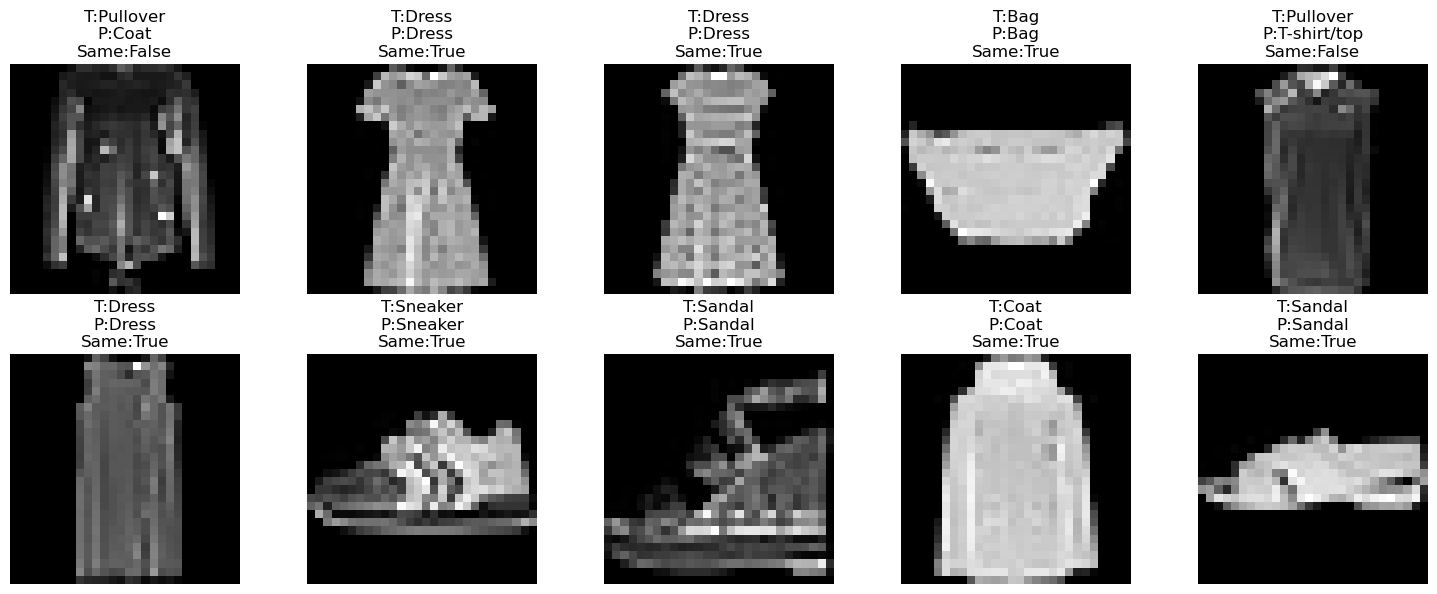

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
train_acc,▁▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇██████████████████
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▃▁▅▅▇▅▆▆▆▇▆▆▆▇█▆▆█▇▇▇▆▇█▇▇▇▆▇▆█▆▇▇▇▇█▇▇▇
val_loss,█▆▅▅▄▃▃▄▅▃▂▃▃▃▃▃▂▃▂▂▂▁▂▂▂▂▄▁▃▁▁▃▂▃▂▂▂▂▂▁
epoch,100
train_acc,95.41273
train_loss,0.12798
val_acc,93.96
val_loss,0.17294


In [30]:
main()

# 문제[3] 학습 완료된 모델로 테스트 데이터 Accuracy 확인하기

## 결과
- Best Model의 파라미터값으로 Test Acc성능(93.30%)

# 문제[4] 샘플 테스트 데이터 분류 예측 결과 확인하기 
- main에서 학습후 Test진행 및 문제[4] 진행하였음.

## - 결과 해석 :
#### 오분류된 사례(0번, 4번)는 공통적으로 클래스 간 형태가 비슷한 의류에서 발생했다.

### Pullover → Coat

#### 두 클래스 모두 긴팔 상의로 실루엣이 매우 유사함

#### 28×28 흑백 이미지에서는 깃/두께 차이가 흐려져 모델이 구분하기 어려움

### Pullover → T-shirt/top

#### 밝기·윤곽이 흐릿한 경우 긴팔이 짧아 보이거나 얇은 상의처럼 인식될 수 있음

#### 저해상도 + Augmentation 영향으로 형태 정보가 약해질 수 있음

## - 결론 :
- 이미지 해상도가 낮고 의류 간 형태가 비슷해, 미세한 차이가 사라진 경우 모델이 혼동한 것으로 판단된다.

# 숙제 후기
이번 과제를 통해 단순히 CNN을 구현하는 것을 넘어, 정규화(Normalization), 규제화(Regularization), 옵티마이저 선택, 데이터 증강 등 실제 성능 향상에 직접적으로 영향을 주는 요소들을 코드로 다루면서, 각각이 어떻게 작용하는지 체감할 수 있었음.

특히 하이퍼파라미터 튜닝을 하면서

learning rate 조절에 따른 수렴 속도 변화,

weight decay와 dropout의 과적합 방지 효과,

BatchNorm이 학습 안정성에 주는 영향,

Augmentation을 통한 정확도 개선 등

같은 부분들이 명확하게 드러나서, 이론으로 배웠던 내용들이 실제 실험에서 어떤 의미를 가지는지 잘 이해할 수 있었음.

마지막으로, 작은 해상도의 Fashion-MNIST에서도 클래스 간 분류 난이도 차이가 존재하고, augmentation이나 regularization이 그 한계를 일부 보완해준다는 점을 확인하며 모델 설계와 데이터 품질의 중요성을 다시 느낄 수 있었음.